# Serotonin 3D GNN Project


This project builds upon research done by Łapińska et al. (2024): https://doi.org/10.3390/pharmaceutics16030349

Data used: https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_35/

Move the unpacked chembl_35_sqlite.tar.gz file into the data/ dir.

The research linked above presents two Quantitative Structure-Activity Relationship (QSAR) models to predict serotonergic binding affinity and selectivity, respectively, using Mordred molecular 2D descriptors. Specifically, one model classifies compounds binarily as "active" or "inactive", with a cutoff of pKi = 7. Another model does multiclass classification to predict the serotonergic selectivity of compounds previously classified as "active".

I am following a similar approach, but using 3D molecular graph representations instead of 2D molecular descriptors as input modality and using only the ChEMBL database, not ZINC.


---

## Setup


### Configuration & Google Drive/Colab Sync


In [1]:
from pathlib import Path

try:
    from google.colab import drive

    drive.mount("/content/drive")
    IN_COLAB = True
except:
    IN_COLAB = False

print(f"{'Running in Colab' if IN_COLAB else 'Running locally'}")

PATH_NOTEBOOK = (
    Path("/content/drive/MyDrive/Colab Notebooks/serotonin-3d-gnn.ipynb")
    if IN_COLAB
    else Path(
        "/Users/paul/Library/CloudStorage/GoogleDrive-unoutsch@gmail.com/My Drive/Colab Notebooks/serotonin-3d-gnn.ipynb"
    )
)
PATH_REPO = (
    Path("/content/drive/MyDrive/Repositories/serotonin-3d-gnn")
    if IN_COLAB
    else Path.cwd()
)
PATH_DATA = PATH_REPO / "data"
PATH_WEIGHTS = PATH_REPO / "weights"

Mounted at /content/drive
Running in Colab


### Installing Requirements


In [2]:
%pip install --requirement "$PATH_REPO/requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Imports


In [3]:
import os
import sys
import time
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from rdkit import Chem
from rdkit.Chem import AllChem, rdchem
import shutil
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

### Syncing this file between Colab and local Git repo


Make sure the paths exist.


In [25]:
def copy_notebook():
    if IN_COLAB:
        shutil.copyfile(PATH_NOTEBOOK, PATH_REPO / "serotonin-3d-gnn.ipynb")
        print("Copied notebook to repo.")
    else:
        shutil.copyfile(PATH_REPO / "serotonin-3d-gnn.ipynb", PATH_NOTEBOOK)
        print("Copied notebook to Google Drive.")


copy_notebook()

Copied notebook to repo.


### Setting Torch Device


In [4]:
if torch.cuda.is_available():
    print("Using CUDA")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using CUDA


---

## Data Preprocessing


In order to collect the desired data from the ChEMBL SQL database and transform it into a .csv file, I undertook the steps detailed in `data/README.md`.


### Loading and Preprocessing Serotonin Data


If the pickled torch_data_list already exists, load it.


In [5]:
pickle_file_path = PATH_DATA / "torch_data_list.pkl"

if os.path.exists(pickle_file_path):
    torch_data_list = pickle.load(open(pickle_file_path, "rb"))
    print("Loaded torch_data_list from pickle file")
else:
    print("Creating torch_data_list from scratch")

df = pd.read_csv(PATH_DATA / "serotonin_binding_summary.csv")

df.describe()

Loaded torch_data_list from pickle file


,molecule_id,Serotonin (5-HT) receptor,Serotonin 1 (5-HT1) receptor,Serotonin 1 receptors; 5-HT1B & 5-HT1D,Serotonin 1a (5-HT1a) receptor,Serotonin 1b (5-HT1b) receptor,Serotonin 1d (5-HT1d) receptor,Serotonin 1e (5-HT1e) receptor,Serotonin 1f (5-HT1f) receptor,Serotonin 2 (5-HT2) receptor,...,Serotonin 2b (5-HT2b) receptor,Serotonin 2c (5-HT2c) receptor,Serotonin 3 (5-HT3) receptor,Serotonin 3a (5-HT3a) receptor,Serotonin 3b (5-HT3b) receptor,Serotonin 4 (5-HT4) receptor,Serotonin 5a (5-HT5a) receptor,Serotonin 5b (5-HT5b) receptor,Serotonin 6 (5-HT6) receptor,Serotonin 7 (5-HT7) receptor
count,2.345600e+04,90.000000,252.000000,1.0,9462.000000,1492.000000,1472.000000,91.000000,127.000000,1469.000000,...,2337.000000,4343.000000,939.000000,1040.000000,8.000000,1009.000000,422.000000,1.00,4221.000000,3100.000000
mean,1.003325e+06,6.081759,6.683902,6.2,7.258523,6.952528,7.554968,5.791172,7.458423,7.053201,...,6.603829,6.810210,7.625768,7.047520,7.203500,7.645809,6.573801,7.17,7.311171,6.977487
std,8.986583e+05,0.926906,1.104283,NaN,1.152004,1.226482,1.365880,0.652239,0.859240,1.159567,...,0.981462,1.032874,1.225942,1.535413,1.735342,1.179482,1.089819,NaN,1.143388,1.016128
min,9.700000e+01,4.390000,4.100000,6.2,4.000000,4.000000,4.000000,4.800000,5.140000,4.030000,...,4.190000,4.000000,4.010000,4.000000,5.460000,5.000000,4.070000,7.17,4.120000,4.000000
25%,2.291570e+05,5.385000,5.800000,6.2,6.480000,6.050000,6.470000,5.360000,7.000000,6.240000,...,5.900000,6.050000,6.800000,5.700000,5.490000,6.810000,5.800000,7.17,6.470000,6.285000
50%,5.757615e+05,5.925000,6.600000,6.2,7.280000,6.850000,7.640000,5.730000,7.720000,6.920000,...,6.523333,6.740000,7.700000,7.185000,7.015000,7.640000,6.390000,7.17,7.360000,6.990000
75%,1.965967e+06,6.657500,7.585000,6.2,8.060000,7.850000,8.700000,6.175000,8.020000,8.000000,...,7.210000,7.512500,8.580000,8.410000,8.393500,8.400000,7.068750,7.17,8.110000,7.700000
max,2.881244e+06,9.800000,9.300000,6.2,11.000000,10.000000,10.700000,8.200000,8.800000,10.300000,...,10.100000,10.700000,10.420000,10.400000,9.604000,10.800000,9.170000,7.17,10.400000,10.000000


Number of targets: 21
Boolean mask: tensor([False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False])
Included targets (1): tensor([3])


<Figure size 2000x1000 with 0 Axes>

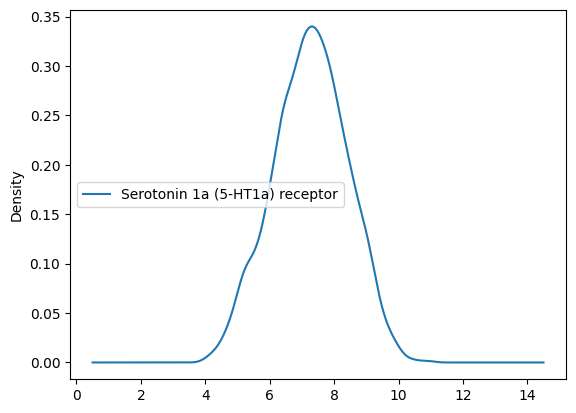

In [6]:
df_targets = df.drop(columns=["molecule_id", "canonical_smiles"])
print(f"Number of targets: {len(df_targets.columns)}")

# compute non-nan counts per column and create a boolean mask to filter targets to contain at least n_threshold non-nan values
n_threshold = 9000
non_nan_counts = torch.tensor(df_targets.notna().sum().values, dtype=torch.long)
mask = non_nan_counts >= n_threshold
valid_column_indices = torch.nonzero(mask, as_tuple=True)[0]

print("Boolean mask:", mask)
print(f"Included targets ({len(valid_column_indices)}):", valid_column_indices)

# pdfs of targets
plt.figure(figsize=(20, 10))
df_targets.iloc[:, valid_column_indices.tolist()].plot.kde()
plt.show()

### Creating 3D Molecular Graph Data from Serotonin Data


In [7]:
periodic_table = rdchem.GetPeriodicTable()

ATOM_PROPERTIES = {
    atomic_num: [
        periodic_table.GetAtomicWeight(atomic_num),
        periodic_table.GetRvdw(atomic_num),
        periodic_table.GetDefaultValence(atomic_num),
    ]
    for atomic_num in range(1, 119)  # all elements in periodic table
}

BOND_TYPES = [
    Chem.rdchem.BondType.SINGLE,
    Chem.rdchem.BondType.AROMATIC,
    Chem.rdchem.BondType.DOUBLE,
    Chem.rdchem.BondType.TRIPLE,
]


def create_torch_data(smiles: str, targets: torch.Tensor) -> Data:
    # getting RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        return None

    # add explicit hydrogen atoms to the molecule (are not included in the SMILES string) so that its 3D structure is complete
    mol = Chem.AddHs(mol)

    # EmbedMolecule positions atoms of mol in 3D space stochastically; if it fails (returning -1) return None
    if AllChem.EmbedMolecule(mol, randomSeed=42) == -1:
        return None

    # optimize the 3D structure using Universal Force Field (UFF) to lower mol's energy
    AllChem.UFFOptimizeMolecule(mol)

    # conformer contains 3D coordinates for mol's atoms
    conformer = mol.GetConformer()

    # atom-level features and 3D positions
    atom_features, positions = [], []
    for atom in mol.GetAtoms():
        atomic_num = atom.GetAtomicNum()
        atomic_mass, vdw_radius, valence = ATOM_PROPERTIES.get(
            atomic_num, [0.0, 0.0, 0]
        )

        features = [
            atomic_mass,
            vdw_radius,
            valence,
            atom.GetFormalCharge(),
            int(atom.GetIsAromatic()),
            atom.GetDegree(),
        ] + [
            1.0 if atom.GetHybridization() == h else 0.0
            for h in (
                Chem.rdchem.HybridizationType.SP,
                Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3,
            )
        ]

        atom_features.append(features)

        pos = conformer.GetAtomPosition(atom.GetIdx())
        positions.append([pos.x, pos.y, pos.z])

    # transform to PyTorch tensors
    x = torch.tensor(atom_features, dtype=torch.float)
    pos = torch.tensor(positions, dtype=torch.float)

    # bonds between atoms – indices of connected atoms as well as types and conjugation
    edge_index, edge_attr = [], []
    for bond in mol.GetBonds():
        # indices of bonded atoms
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()

        # one-hot encode bond type
        bond_type = bond.GetBondType()
        bond_type_one_hot = [1.0 if bond_type == b else 0.0 for b in BOND_TYPES]

        is_conjugated = 1.0 if bond.GetIsConjugated() else 0.0

        bond_feat = bond_type_one_hot + [is_conjugated]

        # adding bond to both nodes
        edge_index += [[i, j], [j, i]]
        edge_attr += [bond_feat, bond_feat]

    # transform to PyTorch tensors
    # edge_index tensor is transposed to fit torch_geometric's expected shape (2, number_of_edges).
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # graph as PyTorch Geometric Data object
    # x: atom features, [atomic number, degree, formal charge, hybridization]
    # pos: 3D positions of atoms, [x, y, z]
    # edge_index: connectivity indices between atoms, [[i, j], [j, i]]
    # edge_attr: features per bond, [[bond type, conjugation], [bond type, conjugation]]
    return Data(
        x=x,
        pos=pos,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=targets,
        smiles=smiles,
    )


if not torch_data_list:
    torch_data_list = []

    for i, row in enumerate(df.itertuples()):
        pct_complete = 100 * i / len(df)
        sys.stdout.write(f"\r{pct_complete:.2f}% complete")
        sys.stdout.flush()

        torch_data_list.append(
            create_torch_data(
                row.canonical_smiles,
                torch.tensor(df_targets.iloc[i].values, dtype=torch.float),
            )
            for i, row in enumerate(df.itertuples(index=False))
        )

    pickle_file_path = PATH_DATA / "torch_data_list.pkl"

    with open(pickle_file_path, "wb") as f:
        pickle.dump(torch_data_list, f)

    print(f"Saved torch_data_list to {pickle_file_path}")

### Splitting Serotonin Data into Train/Test (and Don't Touch the Test Set)


In [8]:
filtered_torch_data_list = [d.clone() for d in torch_data_list if d is not None]
print(
    f"Number of items in filtered_torch_data_list: {len(filtered_torch_data_list)} / {len(torch_data_list)}"
)  # still retaining original torch_data_list for reference to df later
print(f"filtered_torch_data_list[0]: {filtered_torch_data_list[0]}")

new_filtered_torch_data_list = []

# only include targets with at least n_threshold non-nan values
for d in filtered_torch_data_list:
    d.y = d.y[valid_column_indices]
    if not torch.isnan(d.y).all():
        new_filtered_torch_data_list.append(d)

print(
    f"Number of items in new_filtered_torch_data_list: {len(new_filtered_torch_data_list)} / {len(filtered_torch_data_list)}"
)
filtered_torch_data_list = new_filtered_torch_data_list

split_idx = int(0.8 * len(filtered_torch_data_list))

filtered_torch_data_list_train = filtered_torch_data_list[:split_idx]
filtered_torch_data_list_test = filtered_torch_data_list[split_idx:]

y_train = [d.y.cpu().numpy() for d in filtered_torch_data_list_train if d.y.numel() > 0]
y_train_array = np.array(y_train)
sigma_train = np.nanstd(y_train_array, axis=0)

print(filtered_torch_data_list_train[0])

print("Standard deviation of training set:", sigma_train)

Number of items in filtered_torch_data_list: 23439 / 23456
filtered_torch_data_list[0]: Data(x=[49, 9], edge_index=[2, 104], edge_attr=[104, 5], y=[21], pos=[49, 3], smiles='COc1cc2nc(N3CCN(C(=O)c4ccco4)CC3)nc(N)c2cc1OC')
Number of items in new_filtered_torch_data_list: 9460 / 23439
Data(x=[49, 9], edge_index=[2, 104], edge_attr=[104, 5], y=[1], pos=[49, 3], smiles='COc1cc2nc(N3CCN(C(=O)c4ccco4)CC3)nc(N)c2cc1OC')
Standard deviation of training set: [1.1578674]


### Loading ZINC Data


Data used for pre-training: https://www.kaggle.com/datasets/basu369victor/zinc250k?resource=download


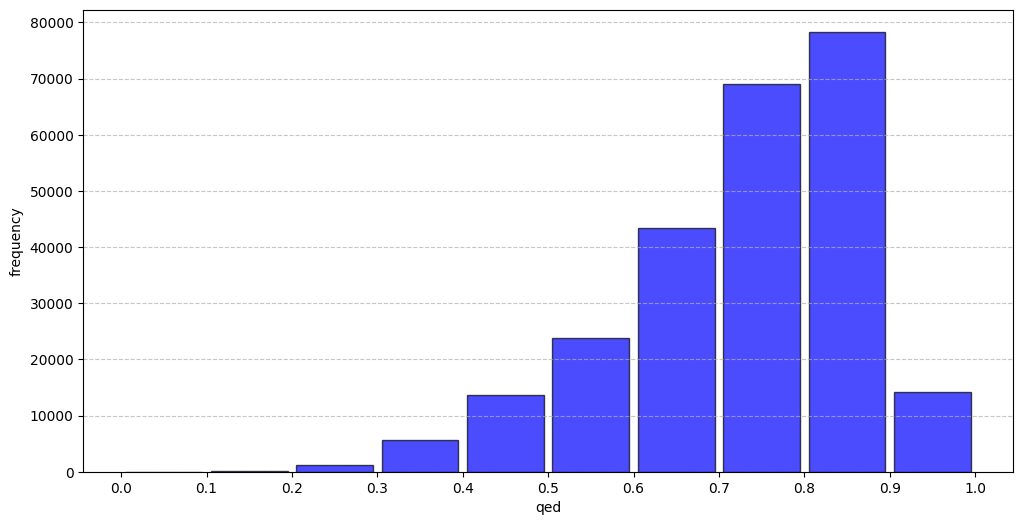

Standard deviation of qed in ZINC: 0.1395650745629226


In [9]:
pretraining_df = pd.read_csv(PATH_DATA / "250k_rndm_zinc_drugs_clean_3.csv")

data_column = pretraining_df.iloc[:, 2]
pretraining_df_sigma = data_column.std()

num_bins = 10

bin_edges = np.arange(0, 1.1, 0.1)
counts, _ = np.histogram(data_column, bins=bin_edges)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.figure(figsize=(12, 6))
plt.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]) * 0.9, alpha=0.7, color='b', edgecolor='black')
plt.xlabel("qed")
plt.ylabel("frequency")
plt.xticks(bin_edges)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

print(f"Standard deviation of qed in ZINC: {pretraining_df_sigma}")

### Creating 3D Molecular Graph Data from ZINC Data


In [11]:
if os.path.exists(PATH_DATA / "pretraining_torch_data_list.pkl"):
    print("Loading pretraining_torch_data_list from pickle file")
    pretraining_torch_data_list = pickle.load(
        open(PATH_DATA / "pretraining_torch_data_list.pkl", "rb")
    )
    print("Done")
else:
    print("Creating pretraining_torch_data_list")
    pretraining_torch_data_list = []
    for i, row in enumerate(pretraining_df.itertuples(index=False)):
        if i % 10 == 0:
            pct_complete = i / len(pretraining_df) * 100
            sys.stdout.write(f"\r{pct_complete:.2f}% complete")
            sys.stdout.flush()

        pretraining_torch_data_list.append(
            create_torch_data(
                row.smiles,
                torch.tensor(
                    [row.qed], dtype=torch.float
                ),  # use QED as target, representing "drug-likeness"
            )
        )

    pickle_file_path = PATH_DATA / "pretraining_torch_data_list.pkl"

    with open(pickle_file_path, "wb") as f:
        pickle.dump(pretraining_torch_data_list, f)

    print(f"Saved pretraining_torch_data_list to {pickle_file_path}")

pretraining_torch_data_list[0]

Loading pretraining_torch_data_list from pickle file
Done


Data(x=[44, 9], edge_index=[2, 92], edge_attr=[92, 5], y=[1], pos=[44, 3], smiles='CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1
')

Remove None objects from the ZINC data.


In [12]:
filtered_pretraining_torch_data_list = [
    d.clone() for d in pretraining_torch_data_list if d is not None
]

print(
    f"Number of items in filtered_pretraining_torch_data_list: {len(filtered_pretraining_torch_data_list)} / {len(pretraining_torch_data_list)}"
)

Number of items in filtered_pretraining_torch_data_list: 249425 / 249455


### Create ZINC subset for hyperparam tuning

Create a new list with the first 10k samples of the ZINC dataset for hyperparam tuning.


In [13]:
if os.path.exists(PATH_DATA / "filtered_pretraining_torch_data_list_10k.pkl"):
    filtered_pretraining_torch_data_list_10k = pickle.load(
        open(PATH_DATA / "filtered_pretraining_torch_data_list_10k.pkl", "rb")
    )
    print("Loaded filtered_pretraining_torch_data_list_10k from pickle file")
else:
    np.random.seed(42)
    np.random.shuffle(filtered_pretraining_torch_data_list)

    filtered_pretraining_torch_data_list_10k = filtered_pretraining_torch_data_list[
        :10000
    ]

    pickle_file_path = PATH_DATA / "filtered_pretraining_torch_data_list_10k.pkl"
    with open(pickle_file_path, "wb") as f:
        pickle.dump(filtered_pretraining_torch_data_list_10k, f)
        print(f"Saved filtered_pretraining_torch_data_list_10k to {pickle_file_path}")

Loaded filtered_pretraining_torch_data_list_10k from pickle file


---

## Model Architectures


### Naive Baseline


In [ ]:
class MeanBaseline:
    def __init__(self):
        self.mean_ = None

    def fit(self, y):
        self.mean_ = np.nanmean(y, axis=0)

    def predict(self, n):
        return np.tile(self.mean_, (n, 1))

### SeroGCN


In [14]:
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear
import torch.nn.functional as F

n_in = filtered_torch_data_list_train[0].x.shape[1]
n_out = len(valid_column_indices)
n_edge_attr = filtered_torch_data_list_train[0].edge_attr.shape[1]

print(f"Node features: {n_in}, targets: {n_out}, edge attributes: {n_edge_attr}")


class SeroGCN(torch.nn.Module):
    def __init__(self, n_hidden):
        super(SeroGCN, self).__init__()

        self.conv1 = GCNConv(n_in, n_hidden)
        self.conv2 = GCNConv(n_hidden, n_hidden)
        self.fc = Linear(n_hidden, n_out)
        self.sigma = 1.0  # distance weighting parameter

    def forward(self, mol_batch) -> torch.Tensor:
        x, pos, edge_index, edge_attr = (
            mol_batch.x,
            mol_batch.pos,
            mol_batch.edge_index,
            mol_batch.edge_attr,
        )

        row, col = edge_index
        eucl_edge_dist = torch.norm(pos[row] - pos[col], p=2, dim=1)
        weight_distance = torch.exp(
            -(eucl_edge_dist**2) / (2 * self.sigma**2)
        )  # Gaussian distance weighting

        # message passing with diustance and angle weights
        x = self.conv1(x, edge_index, edge_weight=weight_distance)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight=weight_distance)
        x = F.relu(x)

        # global pooling for graph-level representation
        x = global_mean_pool(x, mol_batch.batch)
        x = self.fc(x)

        return x

Node features: 9, targets: 1, edge attributes: 5


---

## Training Logic


In [ ]:
# def masked_mse_loss(pred, target):
#     # mask of non-nan targets
#     mask = ~torch.isnan(target)
#     if mask.sum() == 0:
#         # return 0 loss, so that it doesn't affect the gradient
#         return torch.tensor(0.0, requires_grad=True, device=target.device)
#     # squared error for entries that are valid
#     loss = (pred[mask] - target[mask]) ** 2
#     return loss.mean()

In [15]:
def fit(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion,
    epochs: int,
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # --- Training ---
        model.train()
        epoch_loss = 0.0
        start_epoch = time.time()

        for i, data in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(
                out, data.y.view(-1, n_out)
            )  # make sure that even if there's only one target var, it's still a 2D tensor
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            pct_complete = 100 * (i + 1) / len(train_loader)
            sys.stdout.write(
                f"\rEpoch {epoch+1}/{epochs} - {pct_complete:.2f}% complete"
            )
            sys.stdout.flush()

        train_loss_avg = epoch_loss / len(train_loader)

        # --- Validation ---
        model.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            for val_data in val_loader:
                val_data = val_data.to(device)
                val_out = model(val_data)
                val_loss = criterion(val_out, val_data.y.view(-1, n_out))
                val_epoch_loss += val_loss.item()
        val_loss_avg = val_epoch_loss / len(val_loader)
        end_epoch = time.time()

        print(
            f"\nEpoch {epoch+1} completed. Train Loss = {train_loss_avg:.4f} | Val Loss = {val_loss_avg:.4f}. Time taken: {end_epoch - start_epoch:.2f}s"
        )
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)

    return train_losses, val_losses

In [16]:
import copy

from sklearn.model_selection import KFold
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
import torch


def k_fold_cv(
    initialized_model,
    Optimizer,
    criterion,
    dataset,
    k=5,
    epochs=10,
    batch_size=32,
    lr=0.01,
    fit_final_model=False,
):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_train_losses = []
    fold_val_losses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"\n--- Fold {fold+1}/{k} ---")

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model_tmp = copy.deepcopy(initialized_model)
        optimizer_tmp = Optimizer(model_tmp.parameters(), lr=lr)

        train_losses, val_losses = fit(
            model_tmp, train_loader, val_loader, optimizer_tmp, criterion, epochs
        )

        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)

        print(
            f"Fold {fold+1} completed. Final train loss: {train_losses[-1]:.4f} | Final val loss: {val_losses[-1]:.4f}"
        )

    print("\n--- K-Fold CV completed ---")
    print(
        f"Average final train loss: {sum([l[-1] for l in fold_train_losses]) / k:.4f}"
    )
    print(f"Average final val loss: {sum([l[-1] for l in fold_val_losses]) / k:.4f}")

    if fit_final_model:
        print("\nFitting final model on entire dataset")
        optimizer_final = Optimizer(initialized_model.parameters(), lr=lr)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        fit(initialized_model, data_loader, data_loader, optimizer_final, criterion, epochs)

    return fold_train_losses, fold_val_losses

In [17]:
from itertools import product
from sklearn.model_selection import KFold
from torch.utils.data import Subset

hyperparam_grid = {
    # "lr": [0.01, 0.001, 0.0001],
    "lr": [0.01],
    # "batch_size": [16, 32, 64],
    # "n_hidden": [32, 64, 128],
    "n_hidden": [64],
    # "epochs": [10, 20, 30],
    "epochs": [30],
}


def nested_cv(
    Model,
    Optimizer,
    criterion,
    hyperparam_grid,
    dataset,
    k_outer=5,
    k_inner=5,
):
    # list of one dict per parameter combination
    param_combinations = [
        dict(zip(hyperparam_grid.keys(), values))
        for values in product(*hyperparam_grid.values())
    ]
    n_combinations = len(param_combinations)

    # risk estimate for each outer fold and each hyperparam combo
    R_ests = np.zeros((k_outer, n_combinations))

    if k_outer > 1:
      outer_kf = KFold(n_splits=k_outer, shuffle=True, random_state=42)
    else: # for compute reasons
      class DummyKFold:
        def split(self, X):
            yield X, X
      outer_kf = DummyKFold()
    dataset_indices = np.arange(len(dataset))

    for i, (outer_train_idx, outer_val_idx) in enumerate(
        outer_kf.split(dataset_indices)
    ):
        print(f"\n--- Outer Fold {i+1}/{k_outer} ---")

        outer_train_dataset = Subset(dataset, outer_train_idx)
        outer_val_dataset = Subset(dataset, outer_val_idx)

        # per hyperparam combo, perform inner k_fold_cv
        for j, params in enumerate(param_combinations):
            model = Model(params["n_hidden"]).to(device)

            # Run k_fold_cv on the outer training dataset.
            _, fold_val_losses = k_fold_cv(
                initialized_model=model,
                Optimizer=Optimizer,
                criterion=criterion,
                dataset=outer_train_dataset,
                k=k_inner,
                epochs=params["epochs"],
                # batch_size=params["batch_size"],
                batch_size=64, # hard-coded for compute reasons
                lr=params["lr"],
            )
            # average val risk over inner folds
            final_losses = [losses[-1] for losses in fold_val_losses]
            R_est = np.mean(final_losses)
            R_ests[i, j] = R_est
            print(
                f"Outer fold {i+1}, param set {j+1}/{n_combinations}: Risk = {R_est:.4f}"
            )

    # average risk per hyperparam combination over outer folds
    R_ests_params = np.mean(R_ests, axis=0)
    best_idx = np.argmin(R_ests_params)
    best_params = param_combinations[best_idx]

    print(
        f"\nSelected best hyperparameters (avg risk {R_ests_params[best_idx]:.4f}): {best_params}"
    )

    # train final model on full dataset
    model_final = Model(best_params["n_hidden"]).to(device)
    _, final_val_losses = k_fold_cv(
        initialized_model=model_final,
        Optimizer=Optimizer,
        criterion=criterion,
        dataset=dataset,
        k=k_inner,
        epochs=best_params["epochs"],
        # batch_size=params["batch_size"],
        batch_size=64, # hard-coded for compute reasons
        lr=best_params["lr"],
        fit_final_model=True,
    )
    final_R_est = np.mean([losses[-1] for losses in final_val_losses])
    print(f"Final model empirical risk estimate on full dataset: {final_R_est:.4f}")

    return model_final, best_params, final_R_est

---

## Training & Model Selection


### Naive Baseline: Average Prediction


In [ ]:
split_idx_baseline = int(0.8 * len(filtered_torch_data_list_train))

y_train_baseline = [
    d.y.numpy() for d in filtered_torch_data_list_train[:split_idx_baseline]
]
y_val_baseline = [
    d.y.numpy() for d in filtered_torch_data_list_train[split_idx_baseline:]
]

naive_baseline = MeanBaseline()
naive_baseline.fit(y_train_baseline)
naive_baseline_predictions = naive_baseline.predict(len(y_val_baseline))

# compute mse
mse_per_target = np.nanmean((y_val_baseline - naive_baseline_predictions) ** 2, axis=0)
print(f"MSE per target: {mse_per_target}")

MSE per target: [1.1797696]


### Baseline: Random Forest with 2D/3D Descriptors


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from rdkit.Chem import Descriptors

# tried a bunch of descriptor functions from Descriptors._descList – these are the ones that did NOT crash the kernel ...
safe_descriptors = [
    "MolWt",
    "MolLogP",
    "MolMR",
    "NumValenceElectrons",
    "NumRadicalElectrons",
    "HeavyAtomCount",
    "NHOHCount",
    "NOCount",
    "RingCount",
    "FractionCSP3",
    "TPSA",
    "NumHDonors",
    "NumHAcceptors",
    "NumRotatableBonds",
    "HallKierAlpha",
    "Kappa1",
    "Kappa2",
    "Kappa3",
    "Chi0",
    "Chi1",
    "fr_Al_COO",
    "fr_Al_OH",
    "fr_Ar_N",
    "fr_C_O",
    "fr_NH1",
    "fr_NH2",
]

descriptor_functions = {name: getattr(Descriptors, name) for name in safe_descriptors}


# extract a fixed-length feature vector from the graph data, as input to RF model
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    desc_values = []
    for _, func in descriptor_functions.items():
        try:
            desc_values.append(func(mol))
        except:
            print(f"Error computing descriptor {func}")
    return np.array(desc_values)


X = []
y = []
for data in filtered_torch_data_list_train:
    features = compute_descriptors(data.smiles)
    if features is None:
        continue
    X.append(features)
    target_val = data.y.cpu().numpy() if data.y.numel() > 0 else np.nan
    y.append(target_val)

X = np.array(X)
y = np.array(y)

split_idx_rf = int(0.8 * len(filtered_torch_data_list_train))
X_train, X_val = X[:split_idx_rf], X[split_idx_rf:]
y_train, y_val = y[:split_idx_rf], y[split_idx_rf:]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print("Val MSE:", mse)

[15:55:03] UFFTYPER: Unrecognized charge state for atom: 12
[15:55:03] UFFTYPER: Unrecognized charge state for atom: 12
[15:57:22] Interrupted, cancelling conformer generation


KeyboardInterrupt: Embedding cancelled

### Approach 1: SeroGCN without Pretraining


In [ ]:
sero_gcn_final, best_params_sero_gcn, final_R_est_sero_gcn = nested_cv(
    SeroGCN,
    torch.optim.Adam,
    torch.nn.MSELoss(),
    hyperparam_grid,
    filtered_torch_data_list_train,
    k_outer=1, # compute reasons
    k_inner=5,
)

torch.save(sero_gcn_final.state_dict(), PATH_WEIGHTS / "sero_gcn_final_weights.pth")

with open(PATH_WEIGHTS / "best_params_sero.json", "w") as f:
    json.dump(
        {
            "best_params_sero_gcn": best_params_sero_gcn,
            "final_R_est_sero_gcn": final_R_est_sero_gcn,
        },
        f,
    )

### Approach 2: SeroGCN with Pretraining on ZINC


#### Pretraining: Hyperparameter Tuning


In [ ]:
(
    pretrained_sero_gcn,
    best_params_pretrained_sero_gcn,
    final_R_est_pretrained_sero_gcn,
) = nested_cv(
    SeroGCN,
    torch.optim.Adam,
    torch.nn.MSELoss(),
    hyperparam_grid,
    filtered_pretraining_torch_data_list_10k,
    k_outer=1, # compute reasons
    k_inner=5,
)

torch.save(
    pretrained_sero_gcn.state_dict(),
    PATH_WEIGHTS / "pretrained_sero_gcn_pretrained_weights.pth",
)

with open(PATH_WEIGHTS / "best_params_pretrained_sero.json", "w") as f:
    json.dump(
        {
            "best_params_pretrained_sero_gcn": best_params_pretrained_sero_gcn,
            "final_R_est_pretrained_sero_gcn": final_R_est_pretrained_sero_gcn,
        },
        f,
    )


--- Outer Fold 1/1 ---

--- Fold 1/5 ---
Epoch 1/30 - 100.00% complete
Epoch 1 completed. Train Loss = 0.0582 | Val Loss = 0.0175. Time taken: 2.55s
Epoch 2/30 - 100.00% complete
Epoch 2 completed. Train Loss = 0.0188 | Val Loss = 0.0166. Time taken: 1.89s
Epoch 3/30 - 100.00% complete
Epoch 3 completed. Train Loss = 0.0184 | Val Loss = 0.0182. Time taken: 1.42s
Epoch 4/30 - 100.00% complete
Epoch 4 completed. Train Loss = 0.0187 | Val Loss = 0.0165. Time taken: 1.49s
Epoch 5/30 - 100.00% complete
Epoch 5 completed. Train Loss = 0.0177 | Val Loss = 0.0165. Time taken: 1.44s
Epoch 6/30 - 100.00% complete
Epoch 6 completed. Train Loss = 0.0182 | Val Loss = 0.0173. Time taken: 1.49s
Epoch 7/30 - 100.00% complete
Epoch 7 completed. Train Loss = 0.0183 | Val Loss = 0.0163. Time taken: 1.49s
Epoch 8/30 - 100.00% complete
Epoch 8 completed. Train Loss = 0.0181 | Val Loss = 0.0168. Time taken: 1.52s
Epoch 9/30 - 100.00% complete
Epoch 9 completed. Train Loss = 0.0178 | Val Loss = 0.0164. Time

#### (Pretraining: Full ZINC with Locked Hyperparameters)


#### Fine-tuning on Serotonine Data


In [ ]:
pickle_file_path = PATH_WEIGHTS / "pretrained_sero_gcn_pretrained_weights.pth"

if os.path.exists(pickle_file_path) and not pretrained_sero_gcn:
  print("Loading pretrained SeroGCN from weights file")
  pretrained_sero_gcn = torch.load(pickle_file_path, map_location=device)
  print("Loaded pretrained SeroGCN from weights file")
else:
  print("SeroGCN does not exist – train it first")


SeroGCN does not exist – train it first


In [ ]:
_, final_val_losses_pretrained_sero_gcn = k_fold_cv(
    initialized_model=pretrained_sero_gcn,
    Optimizer=torch.optim.Adam,
    criterion=torch.nn.MSELoss(),
    dataset=filtered_torch_data_list_train,
    k=5,
    epochs=best_params_pretrained_sero_gcn["epochs"],
    batch_size=best_params_pretrained_sero_gcn["batch_size"],
    lr=best_params_pretrained_sero_gcn["lr"],
    fit_final_model=True,
)

torch.save(
    pretrained_sero_gcn.state_dict(),
    PATH_WEIGHTS / "pretrained_sero_gcn_final_weights.pth",
)

with open(PATH_WEIGHTS / "best_params_pretrained_sero_final.json", "w") as f:
    json.dump(
        {
            "best_params_pretrained_sero_gcn": best_params_pretrained_sero_gcn,
            "final_R_est_pretrained_sero_gcn": final_val_losses_pretrained_sero_gcn,
        },
        f,
    )

---

## Test Set Evaluation


---

## Conclusion
